In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Subset

import numpy as np
import time
import datetime
import os
import matplotlib.pyplot as plt
from itertools import combinations

from model import DenseNet
from utils import cal_l2, ContrastiveLoss, sigmoid
from dataloader import TestImageFolder
from matplotlib import colors
import math

# Args 

In [14]:
# Model Configuration 
batch_size = 16
lr = 1e-5
crop_size = 3*256

# Data path for Training
# t_hp1_dir = '../76_server/test_patch_2304/hyperplastic/1_hyperplastic_10'
# t_nor1_dir = '../76_server/test_patch_2304/normal/1_normal_10'
t_dir = '../76_server/test_patch_2304/combine' # HP + Normal
t2_dir = '../76_server/test_patch_2304/combine2' # HP + Normal


# Data path for Validation
v_hp1_dir = '../76_server/test_patch_2304/hyperplastic/1_hyperplastic_11'
v_nor1_dir = '../76_server/test_patch_2304/normal/1_normal_11'
v_ta1_dir = '../76_server/test_patch_2304/ta_c_lgd/1_ta_c_lgd_11'

# Data dir for Visual Check
all_hp10_dir = '../212_data/all_1hp10/'
all_hp20_dir = '../212_data/all_1hp20/'

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
contrasive = ContrastiveLoss(margin=2.0)# .to(device)

In [4]:
crop_size = 3*256
transform = transforms.Compose([
                    transforms.CenterCrop((crop_size, crop_size)),
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])


# Val Set
v_hp1_set = ImageFolder(root=v_hp1_dir, transform=transform)
v_nor1_set = ImageFolder(root=v_nor1_dir, transform=transform)
v_ta1_set = ImageFolder(root=v_ta1_dir, transform=transform)
 
# Val Loader
v_hp1_loader = DataLoader(v_hp1_set, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)
v_nor1_loader = DataLoader(v_nor1_set, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)
v_ta1_loader = DataLoader(v_ta1_set, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

# Experiment - 1

# Training With Small dataset 

In [9]:
class Trainer:
    
    def __init__(self, model, minmax_epochs, batch_size, f_lambda=1.0):
        
        # MISC
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.prev_val_f_loss = np.inf
        self.curr_val_f_loss = 0
        
        # Archive for saving mean of features
        self.archive = {}
        self.archive['hp'] = {}
        self.archive['nor'] = {}
        self.archive['ta'] = {}
        
        self.archive['hp']['sum'] = 0
        self.archive['hp']['count'] = 0
        self.archive['hp']['avg'] = 0
        self.archive['nor']['sum'] = 0
        self.archive['nor']['count'] = 0
        self.archive['nor']['avg'] = 0
        self.archive['ta']['sum'] = 0
        self.archive['ta']['count'] = 0
        self.archive['ta']['avg'] = 0
        
        
        # Model & Optimizer 
        self.model = model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), betas=(0.5, 0.99))
        self.model = nn.DataParallel(model)
        
        # Training configuration
        self.transform = transforms.Compose([
                    transforms.CenterCrop((768, 768)),
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])
        self._num_samples = None
        self._data_dir = None
        self.batch_size = batch_size
        self.min_epochs = minmax_epochs[0]
        self.max_epochs = minmax_epochs[1]
        self.batch_size = batch_size
        self.f_lambda = f_lambda

        
    def get_loaders(self):
        """ Prepare data loaders via data directory """
        # It should be replced with procedure where information which have similar index information.. 
        d_set = ImageFolder(root=self._data_dir, transform=self.transform)
        idx = np.random.choice(len(d_set), self._num_samples, replace=False)
        t_idx = np.random.choice(idx, int(self._num_samples*0.8), replace=False)
        v_idx = np.array([xx for xx in idx if xx not in t_idx])
        
        t_subset = Subset(d_set, t_idx)
        v_subset = Subset(d_set, v_idx)
    
        self.t_loader = DataLoader(t_subset, batch_size=self.batch_size, shuffle=True, num_workers=4)
        self.v_loader = DataLoader(v_subset, batch_size=self.batch_size, shuffle=True, num_workers=4)
        
    def reset_cnts(self):
        self.t_total_cnt = 0
        self.t_corr_cnt = 0
        self.v_total_cnt = 0
        self.v_corr_cnt = 0
    
    def train(self):
        
        # Getting Loaders
        self.get_loaders()
        
        # End flag
        self.end = False
        
        for epoch in range(self.max_epochs):
            self.reset_cnts()
        
            ## Train 1-epoch
            self.model.train()
            start_t = time.time()     
            for ii, (image, label) in enumerate(self.t_loader):
#                 print(label)
                image_var = image.to(self.device)
#                 label = self.label.expand(image.size(0)).long()
                label_var = label.to(device)

                # Forwarding & Backwarding 
                ff, output = self.model(image_var)
                f = torch.squeeze(ff)

                # Feature alignment Loss
                f_loss = 0
                f_dic = {}
                B = image.size(0)
                N = len(f[0])

                for k in sorted(label.unique()):
                    f_dic[k.item()] = f[label == k, :]
                
                # Feature distances Loss / Classification Loss 
                f_loss = contrasive(f_dic, B, N)
                cls_loss = criterion(output, label_var)

                # Total Loss / Update 
                loss = cls_loss + self.f_lambda * f_loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Accuaracy Measure
                pred = output.argmax(dim=-1).cpu()
                self.t_corr_cnt += (pred == label).sum().item()    
                self.t_total_cnt += B

                if (ii+1) % 5 == 0:
                    lap = time.time() - start_t
                    elapsed = str(datetime.timedelta(seconds=lap))
                    print('Elapsed [{}]\t'
                          'Epoch [{}/{}]\t'
                          'Iters [{}/{}]\t\t'
                          'Fet Loss [{:.4f}]\t'
                          'Cls Acu. [{:.4f}]'.format(elapsed, epoch+1, self.max_epochs, (ii+1), len(self.t_loader), 
                                                     f_loss.item(), self.t_corr_cnt/self.t_total_cnt))

                # Free memory
                del f, ff, f_dic, loss, f_loss, cls_loss, output, image_var, label_var
#                 if (ii+1) % 1 == 0:
#                     break
                    
            self.validate(epoch)
            if self.min_epochs > epoch + 1:
                self.end = False
            if self.end and self.min_epochs <= epoch + 1:    
                print('==> Break at {} with F-loss {}'.format(epoch+1, self.curr_val_f_loss))        
                break
        # Return model
        self.return_model()

            
        
    def validate(self, epoch):
        # Validate 1-epoch
        self.model.eval()
        for jj, (image, label) in enumerate(self.v_loader):

            image_var = image.to(device)
#             label = self.label.expand(image.size(0)).long()
            label_var = label.to(device)

            # Forwarding & Backwarding 
            ff, output = self.model(image_var)
            f = torch.squeeze(ff)

            # Feature alignment Loss
            f_loss = 0
            f_dic = {}
            B = image.size(0)
            N = len(f[0])

            for k in sorted(label.unique()):
                f_dic[k.item()] = f[label == k, :]

            # Feature distances Loss / Classification Loss 
            f_loss = contrasive(f_dic, B, N)
            cls_loss = criterion(output, label_var)

            # Total Loss Measure
            loss = cls_loss + self.f_lambda * f_loss

            # Accuaracy Measure
            pred = output.argmax(dim=-1).cpu()
            self.v_corr_cnt += (pred == label).sum().item()    
            self.v_total_cnt += B
            self.curr_val_f_loss += f_loss.item()

            if (jj+1) % 1 == 0:
                print('#### Validation\t'
                      'Epoch [{}/{}]\t'
                      'Fet Loss [{:.4f}]\t'
                      'Cls Acu. [{:.4f}]'.format(epoch+1, self.max_epochs, 
                                                 f_loss.item(), self.v_corr_cnt/self.v_total_cnt))

            del f, ff, f_dic, loss, f_loss, cls_loss, output, image_var, label_var


        if self.curr_val_f_loss < self.prev_val_f_loss:
            self.prev_val_f_loss = self.curr_val_f_loss
        else:
            self.end = True
    
    def return_model(self):
        self.update_archive()
        return self.model
    
    
    """ Methods for Hightlighting """ 
    def update_archive(self):
        storage = {}
        storage['hp'] = []
        storage['nor'] = []
        storage['ta'] = []
        
        for image, label in self.t_loader:
            image_var = image.to(self.device) 
            ft, tt = self.model(image_var)
            ft = torch.squeeze(ft.detach())
            _ft = ft.cpu()
            
            if 0 in label:
                storage['hp'].extend([kk.numpy() for kk in _ft[label == 0]])
            if 1 in label:
                storage['nor'].extend([kk.numpy() for kk in _ft[label == 1]])
            if 2 in label:
                storage['ta'].extend([kk.numpy() for kk in _ft[label == 2]])
            
            # Free memory
            del image_var, _ft, ft, tt
        
        # Update by summing and averaging
#         pdb.set_trace();
        try:
            sum_ft_hp = np.asarray(storage['hp']).sum(axis=0)
            self.archive['hp']['sum'] += sum_ft_hp
            self.archive['hp']['count'] += len(storage['hp'])
            self.archive['hp']['avg'] = self.archive['hp']['sum'] / self.archive['hp']['count']
        except:
            pass
        try:
            sum_ft_nor = np.asarray(storage['nor']).sum(axis=0)
            self.archive['nor']['sum'] += sum_ft_nor
            self.archive['nor']['count'] += len(storage['nor'])
            self.archive['nor']['avg'] = self.archive['nor']['sum'] / self.archive['nor']['count']
        except:
            pass
        try:
            sum_ft_ta = np.asarray(storage['ta']).sum(axis=0)
            self.archive['ta']['sum'] += sum_ft_ta
            self.archive['ta']['count'] += len(storage['ta'])
            self.archive['ta']['avg'] = self.archive['ta']['sum'] / self.archive['ta']['count']
        except:
            pass

        
    def viz_WSI_ft(self, whole_path, whole_hw, alpha, label, dis_th):
        """
        :whole_path - Directory of file where whole image patchese contain
        :whole_hw   - Height and Width value of whold slide image for confine map sized
        :alpha      - Weight value for adjusting softmax value and distance between feature vector mean and feature
        :label      - Indicator for where to highlight
        :dis_th     - Distance thresholding ==>  Temporary delete
        """
        # 
        label_to_id = {'hp':0, 'normal': 1, 'ta': 2}
        target = label_to_id[label]
        
        # Data Path
        w_set = TestImageFolder(root=whole_path, transform=self.transform)
        w_loader = DataLoader(w_set, 
                              batch_size=self.batch_size,
                              shuffle=True,
                              num_workers=4)
        
        # Create empty map
        self.wh = whole_hw[0]
        self.ww = whole_hw[1]
        self.map1x1 = np.zeros((self.wh // 256, self.ww // 256))
        
        # Check for distance value
        self.total_dis = []
        
        # Forwarding.. 
        self.model.eval()
        
        for image, _, image_name in w_loader:
            image_var = image.to(device)
            feature, cofidence = self.model(image_var)
            feature = torch.squeeze(feature)
            
            # Calculate distance for given label 
            _feature = feature.detach().cpu().numpy()
            cls_vec = self.archive[label]['avg']
            ex_ft = np.repeat(cls_vec[np.newaxis, :], image.size(0), axis=0)
            # print(feature.shape, ex_ft.shape)
            feature_dis = np.sqrt(np.power(_feature - ex_ft, 2).sum(axis=-1) + 1e-5)
            
            
            # Calculate Total distance ## Distance + Uncertainty
            total_dis = (1-alpha) * sigmoid(feature_dis) + alpha * (1-cofidence[:, target].detach().cpu().numpy())
            
            
            # Fill prediction map in
            for ii in range(image.size(0)):
                if total_dis[ii] < dis_th:
                    _image_name = image_name[ii].split(',')
                    x, y = int(_image_name[2]) // 256, int(_image_name[1]) // 256
                    self.map1x1[x, y] = target + 1

            # Check for distance value
            self.total_dis.extend(total_dis)
            
            # Free memory
            del image_var, feature, _feature, feature_dis, cofidence, total_dis
            
        
        # Print out map
        # Background - Black, HP - Blue, Normal - Green, TA - Red
        cmap = colors.ListedColormap(['k', 'b', 'g','r'])
        plt.imshow(self.map1x1, cmap=cmap)
        plt.show()
    
    def sx_validate(self, data_path):
        """ Validate trained model for otehr data """
        
        d_set = ImageFolder(root=data_path, transform=self.transform)
        d_loader = DataLoader(d_set, batch_size=self.batch_size, shuffle=True, num_workers=4)
        
        
        total_cnt = 0
        corr_cnt = 0
        
        self.model.eval()
        for jj, (image, label) in enumerate(d_loader):

            image_var = image.to(device)
            label_var = label.to(device)

            # Forwarding & Backwarding 
            ff, output = self.model(image_var)

            # Accuaracy Measure
            pred = output.argmax(dim=-1).cpu()
            
            idx = (label != 2) 
            
            corr_cnt += (pred == label)[idx].sum().item()    
            total_cnt += idx.sum().item()
            
            if (jj+1) % 1 == 0:
                print('#### Validation\t'
                      'Cls Acu. [{:.4f}]'.format(corr_cnt/total_cnt))

            del ff, output, image_var, label_var
        
    
    
    @property
    def data_dir(self):
        return self._data_dir
    
    @data_dir.setter
    def data_dir(self, data_dir):
        self._data_dir = data_dir
        
    @property
    def num_samples(self):
        return self._num_samples
    
    @num_samples.setter
    def num_samples(self, num_samples):
        self._num_samples = num_samples
        
    @property
    def curr_label(self):
        return self._curr_label
    
    @curr_label.setter
    def curr_label(self, curr_label):
        self._curr_label = curr_label

In [10]:
# Model
model = DenseNet(growthRate=32, depth=24, reduction=0.5, bottleneck=True, nClasses=3)

In [11]:
# Trainer
trainer = Trainer(model=model, minmax_epochs=(10, 30), batch_size=16, f_lambda=2.0)

In [12]:
# Train with hp1 200 patches
trainer.data_dir = t_dir
trainer.num_samples = 400
trainer.train()

Elapsed [0:00:02.701593]	Epoch [1/30]	Iters [5/20]		Fet Loss [46.5774]	Cls Acu. [0.4500]
Elapsed [0:00:04.072809]	Epoch [1/30]	Iters [10/20]		Fet Loss [24.8818]	Cls Acu. [0.5437]
Elapsed [0:00:05.509322]	Epoch [1/30]	Iters [15/20]		Fet Loss [21.9350]	Cls Acu. [0.5667]
Elapsed [0:00:06.933851]	Epoch [1/30]	Iters [20/20]		Fet Loss [13.0402]	Cls Acu. [0.6125]
#### Validation	Epoch [1/30]	Fet Loss [24.1361]	Cls Acu. [0.4375]
#### Validation	Epoch [1/30]	Fet Loss [19.2987]	Cls Acu. [0.4375]
#### Validation	Epoch [1/30]	Fet Loss [20.9476]	Cls Acu. [0.5000]
#### Validation	Epoch [1/30]	Fet Loss [31.1432]	Cls Acu. [0.4688]
#### Validation	Epoch [1/30]	Fet Loss [26.8367]	Cls Acu. [0.4500]
Elapsed [0:00:02.696377]	Epoch [2/30]	Iters [5/20]		Fet Loss [8.0774]	Cls Acu. [0.9625]
Elapsed [0:00:04.063392]	Epoch [2/30]	Iters [10/20]		Fet Loss [10.3076]	Cls Acu. [0.9187]
Elapsed [0:00:05.428794]	Epoch [2/30]	Iters [15/20]		Fet Loss [11.8154]	Cls Acu. [0.9333]
Elapsed [0:00:06.820939]	Epoch [2/30]	Iters

/home/kangyeol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in double_scalars


## Validate  for other dataset

In [13]:
trainer.sx_validate(data_path='../76_server/patch_2304/val')

#### Validation	Cls Acu. [0.9000]
#### Validation	Cls Acu. [0.7391]
#### Validation	Cls Acu. [0.7500]
#### Validation	Cls Acu. [0.7500]
#### Validation	Cls Acu. [0.7308]
#### Validation	Cls Acu. [0.7419]
#### Validation	Cls Acu. [0.7183]
#### Validation	Cls Acu. [0.7160]
#### Validation	Cls Acu. [0.7097]
#### Validation	Cls Acu. [0.7282]
#### Validation	Cls Acu. [0.7105]
#### Validation	Cls Acu. [0.6984]
#### Validation	Cls Acu. [0.6788]
#### Validation	Cls Acu. [0.6577]
#### Validation	Cls Acu. [0.6478]
#### Validation	Cls Acu. [0.6627]
#### Validation	Cls Acu. [0.6573]
#### Validation	Cls Acu. [0.6649]
#### Validation	Cls Acu. [0.6701]
#### Validation	Cls Acu. [0.6762]
#### Validation	Cls Acu. [0.6742]
#### Validation	Cls Acu. [0.6638]
#### Validation	Cls Acu. [0.6802]
#### Validation	Cls Acu. [0.6822]
#### Validation	Cls Acu. [0.6900]
#### Validation	Cls Acu. [0.6915]
#### Validation	Cls Acu. [0.6858]
#### Validation	Cls Acu. [0.6861]
#### Validation	Cls Acu. [0.6930]
#### Validatio

#### Validation	Cls Acu. [0.7163]
#### Validation	Cls Acu. [0.7154]
#### Validation	Cls Acu. [0.7157]
#### Validation	Cls Acu. [0.7159]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7172]
#### Validation	Cls Acu. [0.7174]
#### Validation	Cls Acu. [0.7181]
#### Validation	Cls Acu. [0.7173]
#### Validation	Cls Acu. [0.7172]
#### Validation	Cls Acu. [0.7181]
#### Validation	Cls Acu. [0.7178]
#### Validation	Cls Acu. [0.7164]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7163]
#### Validation	Cls Acu. [0.7161]
#### Validation	Cls Acu. [0.7171]
#### Validation	Cls Acu. [0.7170]
#### Validation	Cls Acu. [0.7170]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7169]
#### Validation	Cls Acu. [0.7174]
#### Validation	Cls Acu. [0.7173]
#### Validation	Cls Acu. [0.7167]
#### Validation	Cls Acu. [0.7174]
#### Validation	Cls Acu. [0.7174]
#### Validation	Cls Acu. [0.7172]
#### Validation	Cls Acu. [0.7173]
#### Validatio

#### Validation	Cls Acu. [0.7140]
#### Validation	Cls Acu. [0.7138]
#### Validation	Cls Acu. [0.7141]
#### Validation	Cls Acu. [0.7138]
#### Validation	Cls Acu. [0.7133]
#### Validation	Cls Acu. [0.7138]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7136]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7132]
#### Validation	Cls Acu. [0.7126]
#### Validation	Cls Acu. [0.7122]
#### Validation	Cls Acu. [0.7122]
#### Validation	Cls Acu. [0.7127]
#### Validation	Cls Acu. [0.7123]
#### Validation	Cls Acu. [0.7127]
#### Validation	Cls Acu. [0.7127]
#### Validation	Cls Acu. [0.7126]
#### Validation	Cls Acu. [0.7122]
#### Validation	Cls Acu. [0.7122]
#### Validation	Cls Acu. [0.7123]
#### Validation	Cls Acu. [0.7122]
#### Validation	Cls Acu. [0.7122]
#### Validation	Cls Acu. [0.7120]
#### Validation	Cls Acu. [0.7122]
#### Validation	Cls Acu. [0.7125]
#### Validation	Cls Acu. [0.7123]
#### Validation	Cls Acu. [0.7127]
#### Validation	Cls Acu. [0.7130]
#### Validatio

#### Validation	Cls Acu. [0.7181]
#### Validation	Cls Acu. [0.7181]
#### Validation	Cls Acu. [0.7182]
#### Validation	Cls Acu. [0.7183]
#### Validation	Cls Acu. [0.7184]
#### Validation	Cls Acu. [0.7183]
#### Validation	Cls Acu. [0.7182]
#### Validation	Cls Acu. [0.7181]
#### Validation	Cls Acu. [0.7183]
#### Validation	Cls Acu. [0.7182]
#### Validation	Cls Acu. [0.7183]
#### Validation	Cls Acu. [0.7186]
#### Validation	Cls Acu. [0.7187]
#### Validation	Cls Acu. [0.7187]
#### Validation	Cls Acu. [0.7187]
#### Validation	Cls Acu. [0.7188]
#### Validation	Cls Acu. [0.7187]
#### Validation	Cls Acu. [0.7187]
#### Validation	Cls Acu. [0.7189]
#### Validation	Cls Acu. [0.7188]
#### Validation	Cls Acu. [0.7190]
#### Validation	Cls Acu. [0.7188]
#### Validation	Cls Acu. [0.7188]
#### Validation	Cls Acu. [0.7187]
#### Validation	Cls Acu. [0.7187]
#### Validation	Cls Acu. [0.7185]
#### Validation	Cls Acu. [0.7183]
#### Validation	Cls Acu. [0.7186]
#### Validation	Cls Acu. [0.7186]
#### Validatio

#### Validation	Cls Acu. [0.7173]
#### Validation	Cls Acu. [0.7173]
#### Validation	Cls Acu. [0.7172]
#### Validation	Cls Acu. [0.7172]
#### Validation	Cls Acu. [0.7172]
#### Validation	Cls Acu. [0.7172]
#### Validation	Cls Acu. [0.7170]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7167]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7169]
#### Validation	Cls Acu. [0.7167]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7167]
#### Validation	Cls Acu. [0.7169]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7164]
#### Validation	Cls Acu. [0.7163]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7166]
#### Validatio

#### Validation	Cls Acu. [0.7164]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7163]
#### Validation	Cls Acu. [0.7163]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7167]
#### Validation	Cls Acu. [0.7167]
#### Validation	Cls Acu. [0.7168]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7164]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7167]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7165]
#### Validation	Cls Acu. [0.7166]
#### Validation	Cls Acu. [0.7164]
#### Validation	Cls Acu. [0.7163]
#### Validation	Cls Acu. [0.7161]
#### Validation	Cls Acu. [0.7162]
#### Validation	Cls Acu. [0.7161]
#### Validatio

#### Validation	Cls Acu. [0.7134]
#### Validation	Cls Acu. [0.7133]
#### Validation	Cls Acu. [0.7133]
#### Validation	Cls Acu. [0.7134]
#### Validation	Cls Acu. [0.7133]
#### Validation	Cls Acu. [0.7134]
#### Validation	Cls Acu. [0.7135]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7136]
#### Validation	Cls Acu. [0.7138]
#### Validation	Cls Acu. [0.7138]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7136]
#### Validation	Cls Acu. [0.7136]
#### Validation	Cls Acu. [0.7136]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7138]
#### Validation	Cls Acu. [0.7138]
#### Validation	Cls Acu. [0.7138]
#### Validation	Cls Acu. [0.7136]
#### Validation	Cls Acu. [0.7136]
#### Validation	Cls Acu. [0.7135]
#### Validatio

#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7137]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7140]
#### Validation	Cls Acu. [0.7140]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7139]
#### Validation	Cls Acu. [0.7140]
#### Validation	Cls Acu. [0.7141]
#### Validation	Cls Acu. [0.7141]
#### Validation	Cls Acu. [0.7142]
#### Validation	Cls Acu. [0.7142]
#### Validation	Cls Acu. [0.7143]
#### Validation	Cls Acu. [0.7143]
#### Validation	Cls Acu. [0.7141]
#### Validation	Cls Acu. [0.7141]
#### Validation	Cls Acu. [0.7142]
#### Validation	Cls Acu. [0.7142]
#### Validation	Cls Acu. [0.7143]
#### Validation	Cls Acu. [0.7143]
#### Validation	Cls Acu. [0.7145]
#### Validation	Cls Acu. [0.7145]
#### Validation	Cls Acu. [0.7145]
#### Validation	Cls Acu. [0.7146]
#### Validatio

#### Validation	Cls Acu. [0.7147]
#### Validation	Cls Acu. [0.7147]
#### Validation	Cls Acu. [0.7148]
#### Validation	Cls Acu. [0.7146]
#### Validation	Cls Acu. [0.7147]
#### Validation	Cls Acu. [0.7147]
#### Validation	Cls Acu. [0.7147]


In [15]:
# Train with hp1 200 patches
trainer.data_dir = t2_dir
trainer.num_samples = 400
trainer.train()

Elapsed [0:00:03.150798]	Epoch [1/30]	Iters [5/20]		Fet Loss [12.5432]	Cls Acu. [0.9500]
Elapsed [0:00:04.689918]	Epoch [1/30]	Iters [10/20]		Fet Loss [6.1745]	Cls Acu. [0.9563]
Elapsed [0:00:06.159265]	Epoch [1/30]	Iters [15/20]		Fet Loss [11.5544]	Cls Acu. [0.9708]
Elapsed [0:00:07.753383]	Epoch [1/30]	Iters [20/20]		Fet Loss [5.0088]	Cls Acu. [0.9750]
#### Validation	Epoch [1/30]	Fet Loss [16.1989]	Cls Acu. [0.6875]
#### Validation	Epoch [1/30]	Fet Loss [22.2011]	Cls Acu. [0.7188]
#### Validation	Epoch [1/30]	Fet Loss [20.8518]	Cls Acu. [0.7500]
#### Validation	Epoch [1/30]	Fet Loss [21.3005]	Cls Acu. [0.7500]
#### Validation	Epoch [1/30]	Fet Loss [13.3876]	Cls Acu. [0.7250]
Elapsed [0:00:02.859840]	Epoch [2/30]	Iters [5/20]		Fet Loss [6.8224]	Cls Acu. [0.9875]
Elapsed [0:00:04.253653]	Epoch [2/30]	Iters [10/20]		Fet Loss [1.7555]	Cls Acu. [0.9750]
Elapsed [0:00:05.702319]	Epoch [2/30]	Iters [15/20]		Fet Loss [1.9707]	Cls Acu. [0.9708]
Elapsed [0:00:07.115072]	Epoch [2/30]	Iters [20

/home/kangyeol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
trainer.sx_validate(data_path='../76_server/patch_2304/val')

#### Validation	Cls Acu. [0.6154]
#### Validation	Cls Acu. [0.6154]
#### Validation	Cls Acu. [0.6579]
#### Validation	Cls Acu. [0.6863]
#### Validation	Cls Acu. [0.6774]
#### Validation	Cls Acu. [0.7067]
#### Validation	Cls Acu. [0.6977]
#### Validation	Cls Acu. [0.7158]
#### Validation	Cls Acu. [0.7009]
#### Validation	Cls Acu. [0.7083]
#### Validation	Cls Acu. [0.7023]
#### Validation	Cls Acu. [0.7183]
#### Validation	Cls Acu. [0.7315]
#### Validation	Cls Acu. [0.7358]
#### Validation	Cls Acu. [0.7381]
#### Validation	Cls Acu. [0.7222]
#### Validation	Cls Acu. [0.7202]
#### Validation	Cls Acu. [0.7233]
#### Validation	Cls Acu. [0.7339]
#### Validation	Cls Acu. [0.7316]
#### Validation	Cls Acu. [0.7202]
#### Validation	Cls Acu. [0.7244]
#### Validation	Cls Acu. [0.7321]
#### Validation	Cls Acu. [0.7309]
#### Validation	Cls Acu. [0.7343]
#### Validation	Cls Acu. [0.7391]
#### Validation	Cls Acu. [0.7379]
#### Validation	Cls Acu. [0.7422]
#### Validation	Cls Acu. [0.7433]
#### Validatio

#### Validation	Cls Acu. [0.7266]
#### Validation	Cls Acu. [0.7276]
#### Validation	Cls Acu. [0.7270]
#### Validation	Cls Acu. [0.7280]
#### Validation	Cls Acu. [0.7289]
#### Validation	Cls Acu. [0.7292]
#### Validation	Cls Acu. [0.7291]
#### Validation	Cls Acu. [0.7300]
#### Validation	Cls Acu. [0.7299]
#### Validation	Cls Acu. [0.7303]
#### Validation	Cls Acu. [0.7301]
#### Validation	Cls Acu. [0.7302]
#### Validation	Cls Acu. [0.7305]
#### Validation	Cls Acu. [0.7305]
#### Validation	Cls Acu. [0.7302]
#### Validation	Cls Acu. [0.7307]
#### Validation	Cls Acu. [0.7306]
#### Validation	Cls Acu. [0.7301]
#### Validation	Cls Acu. [0.7302]
#### Validation	Cls Acu. [0.7301]
#### Validation	Cls Acu. [0.7298]
#### Validation	Cls Acu. [0.7295]
#### Validation	Cls Acu. [0.7297]
#### Validation	Cls Acu. [0.7298]
#### Validation	Cls Acu. [0.7301]
#### Validation	Cls Acu. [0.7302]
#### Validation	Cls Acu. [0.7303]
#### Validation	Cls Acu. [0.7309]
#### Validation	Cls Acu. [0.7313]
#### Validatio

#### Validation	Cls Acu. [0.7318]
#### Validation	Cls Acu. [0.7316]
#### Validation	Cls Acu. [0.7314]
#### Validation	Cls Acu. [0.7315]
#### Validation	Cls Acu. [0.7317]
#### Validation	Cls Acu. [0.7319]
#### Validation	Cls Acu. [0.7318]
#### Validation	Cls Acu. [0.7315]
#### Validation	Cls Acu. [0.7309]
#### Validation	Cls Acu. [0.7310]
#### Validation	Cls Acu. [0.7310]
#### Validation	Cls Acu. [0.7313]
#### Validation	Cls Acu. [0.7312]
#### Validation	Cls Acu. [0.7311]
#### Validation	Cls Acu. [0.7308]
#### Validation	Cls Acu. [0.7313]
#### Validation	Cls Acu. [0.7310]
#### Validation	Cls Acu. [0.7314]
#### Validation	Cls Acu. [0.7313]
#### Validation	Cls Acu. [0.7314]
#### Validation	Cls Acu. [0.7315]
#### Validation	Cls Acu. [0.7309]
#### Validation	Cls Acu. [0.7307]
#### Validation	Cls Acu. [0.7305]
#### Validation	Cls Acu. [0.7308]
#### Validation	Cls Acu. [0.7309]
#### Validation	Cls Acu. [0.7308]
#### Validation	Cls Acu. [0.7308]
#### Validation	Cls Acu. [0.7311]
#### Validatio

#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7251]
#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7256]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7249]
#### Validation	Cls Acu. [0.7248]
#### Validation	Cls Acu. [0.7246]
#### Validation	Cls Acu. [0.7243]
#### Validation	Cls Acu. [0.7244]
#### Validation	Cls Acu. [0.7243]
#### Validation	Cls Acu. [0.7246]
#### Validation	Cls Acu. [0.7245]
#### Validation	Cls Acu. [0.7244]
#### Validation	Cls Acu. [0.7246]
#### Validation	Cls Acu. [0.7246]
#### Validation	Cls Acu. [0.7246]
#### Validation	Cls Acu. [0.7243]
#### Validation	Cls Acu. [0.7244]
#### Validation	Cls Acu. [0.7244]
#### Validation	Cls Acu. [0.7246]
#### Validation	Cls Acu. [0.7244]
#### Validatio

#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7234]
#### Validation	Cls Acu. [0.7234]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7237]
#### Validation	Cls Acu. [0.7238]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7238]
#### Validation	Cls Acu. [0.7238]
#### Validation	Cls Acu. [0.7238]
#### Validation	Cls Acu. [0.7240]
#### Validation	Cls Acu. [0.7238]
#### Validation	Cls Acu. [0.7239]
#### Validation	Cls Acu. [0.7237]
#### Validation	Cls Acu. [0.7238]
#### Validation	Cls Acu. [0.7239]
#### Validation	Cls Acu. [0.7240]
#### Validation	Cls Acu. [0.7240]
#### Validation	Cls Acu. [0.7239]
#### Validation	Cls Acu. [0.7240]
#### Validation	Cls Acu. [0.7242]
#### Validation	Cls Acu. [0.7242]
#### Validation	Cls Acu. [0.7242]
#### Validation	Cls Acu. [0.7240]
#### Validation	Cls Acu. [0.7242]
#### Validatio

#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7251]
#### Validation	Cls Acu. [0.7250]
#### Validation	Cls Acu. [0.7249]
#### Validation	Cls Acu. [0.7250]
#### Validation	Cls Acu. [0.7251]
#### Validation	Cls Acu. [0.7250]
#### Validation	Cls Acu. [0.7251]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7252]
#### Validation	Cls Acu. [0.7251]
#### Validation	Cls Acu. [0.7251]
#### Validation	Cls Acu. [0.7250]
#### Validation	Cls Acu. [0.7249]
#### Validation	Cls Acu. [0.7248]
#### Validation	Cls Acu. [0.7248]
#### Validation	Cls Acu. [0.7248]
#### Validation	Cls Acu. [0.7247]
#### Validation	Cls Acu. [0.7246]
#### Validatio

#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7256]
#### Validation	Cls Acu. [0.7257]
#### Validation	Cls Acu. [0.7256]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7256]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7257]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7256]
#### Validation	Cls Acu. [0.7256]
#### Validation	Cls Acu. [0.7255]
#### Validation	Cls Acu. [0.7254]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7253]
#### Validation	Cls Acu. [0.7253]
#### Validatio

#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7234]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7237]
#### Validation	Cls Acu. [0.7237]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7234]
#### Validation	Cls Acu. [0.7234]
#### Validation	Cls Acu. [0.7233]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7236]
#### Validation	Cls Acu. [0.7235]
#### Validation	Cls Acu. [0.7237]
#### Validation	Cls Acu. [0.7237]
#### Validation	Cls Acu. [0.7238]
#### Validation	Cls Acu. [0.7238]
#### Validation	Cls Acu. [0.7239]
#### Validation	Cls Acu. [0.7240]
#### Validatio

## Test with All data from hp10

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 17, 17

## Experiment - 1 alpha adjustment with fixed dis_th

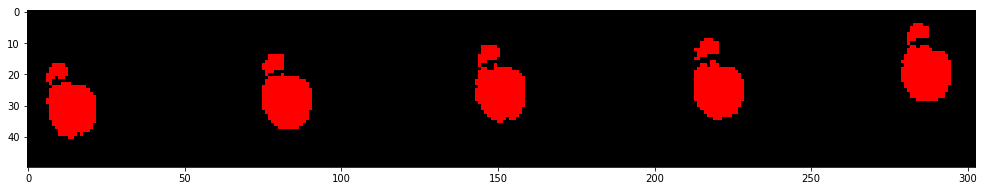

In [10]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=1.0, label='hp', dis_th=0.5) # Use only softmax

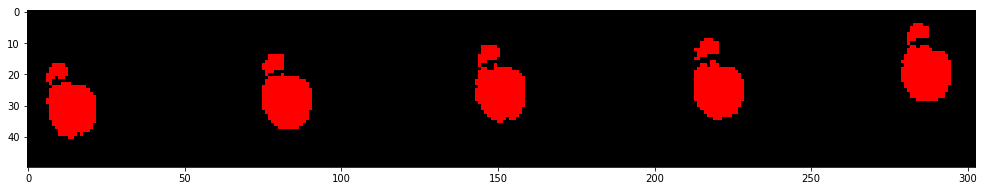

In [11]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.8, label='hp', dis_th=0.5)

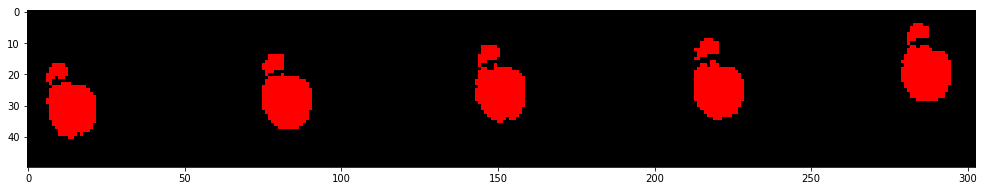

In [12]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.6, label='hp', dis_th=0.5)

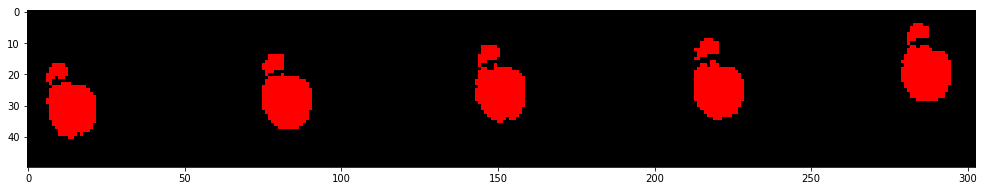

In [13]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.4, label='hp', dis_th=0.5)

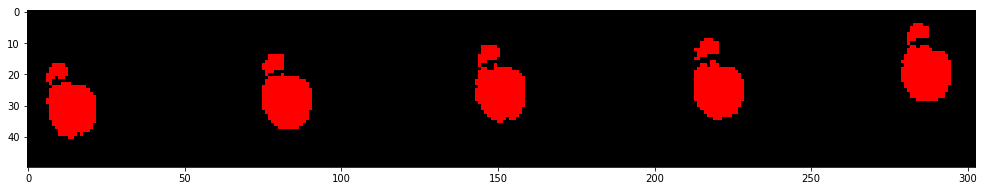

In [14]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.2, label='hp', dis_th=0.5)

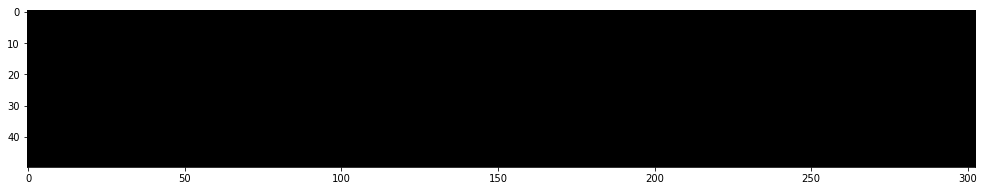

In [15]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.0, label='hp', dis_th=0.5)

## dis_th = 0.8

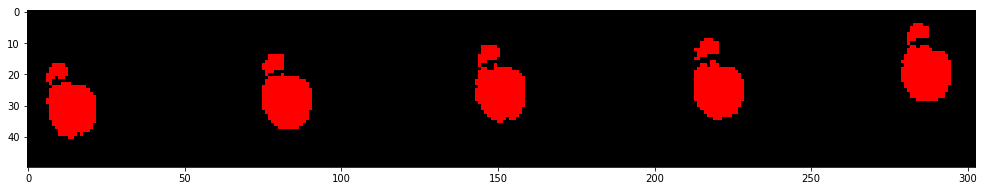

In [16]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=1.0, label='hp', dis_th=0.8)

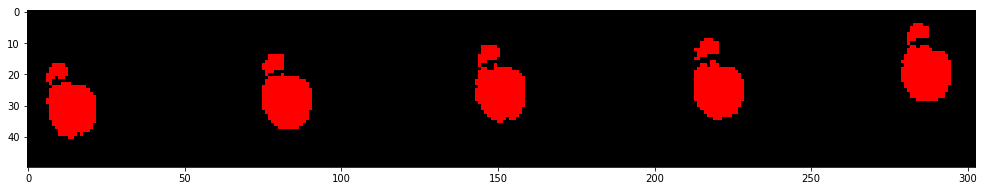

In [17]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.8, label='hp', dis_th=0.8)

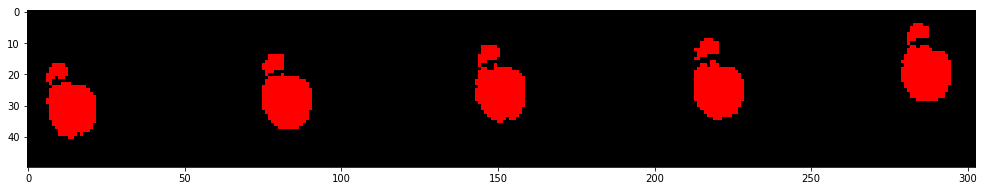

In [18]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.6, label='hp', dis_th=0.8)

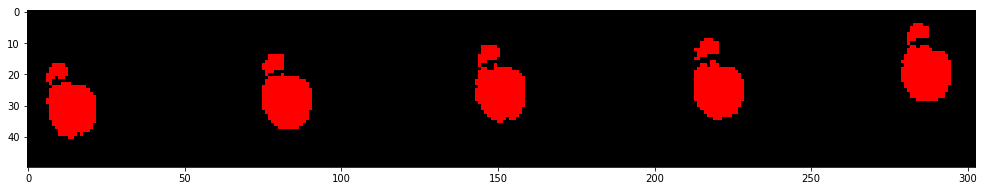

In [19]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.4, label='hp', dis_th=0.8)

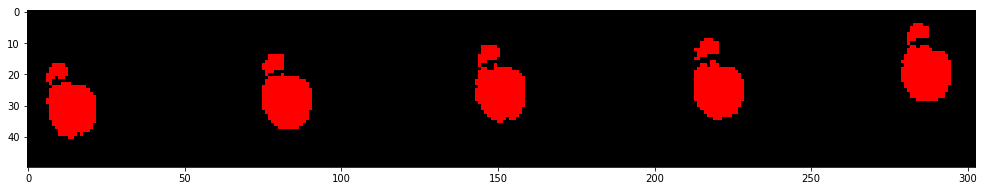

In [20]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.2, label='hp', dis_th=0.8)

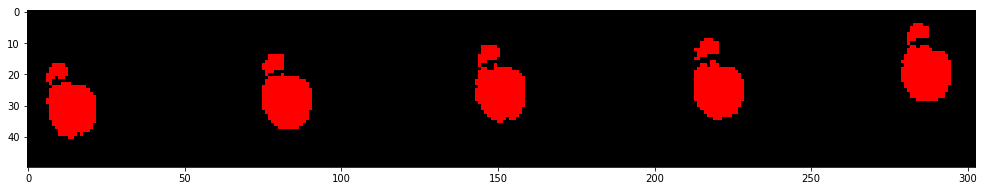

In [21]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.0, label='hp', dis_th=0.8)

## dis_th = 0.3

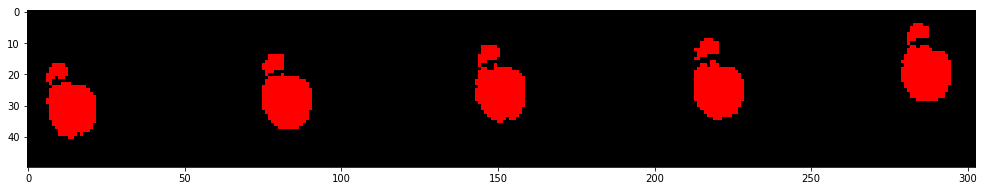

In [22]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=1.0, label='hp', dis_th=0.3)

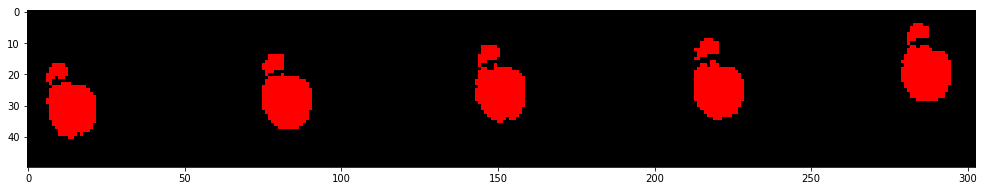

In [23]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.8, label='hp', dis_th=0.3)

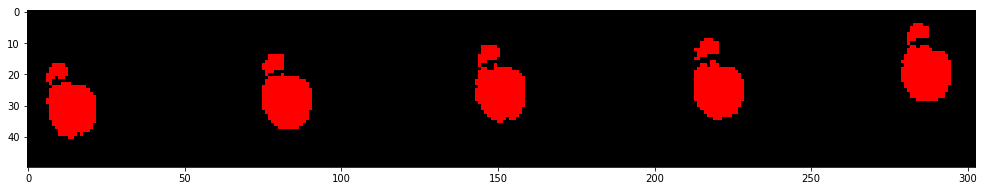

In [24]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.6, label='hp', dis_th=0.3)

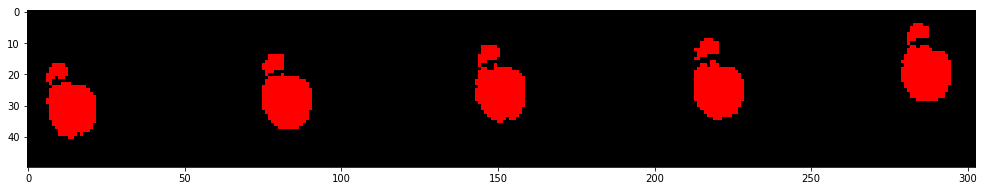

In [25]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.4, label='hp', dis_th=0.3)

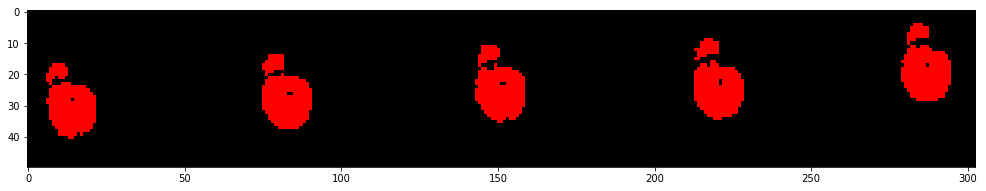

In [26]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.2, label='hp', dis_th=0.3)

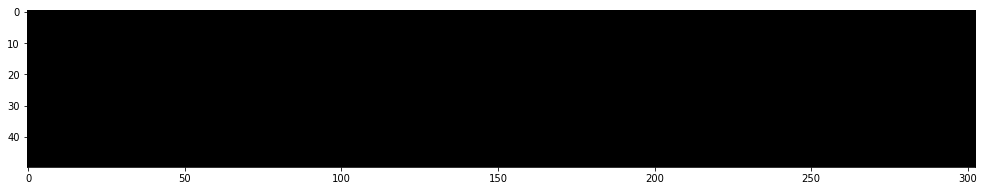

In [27]:
trainer.viz_WSI_ft(whole_path=all_hp10_dir, whole_hw=(12955, 77687), alpha=0.0, label='hp', dis_th=0.3)

In [30]:
print(trainer.total_dis)

[0.59662634, 0.6122403, 0.63057464, 0.5609249, 0.58347064, 0.62391406, 0.6226473, 0.6791609, 0.5514199, 0.5649057, 0.6640835, 0.5947869, 0.63028514, 0.56155765, 0.6309587, 0.5815534, 0.5679241, 0.5931294, 0.6035835, 0.56624615, 0.6404982, 0.55953836, 0.5631995, 0.59917355, 0.60465306, 0.5469827, 0.55559504, 0.5681472, 0.5684827, 0.585361, 0.5834555, 0.559541, 0.54565144, 0.5844306, 0.55897224, 0.6208116, 0.57430816, 0.5531995, 0.574205, 0.62926173, 0.61491853, 0.6039019, 0.56230825, 0.5983477, 0.69024235, 0.57013357, 0.56125385, 0.67714274, 0.6243924, 0.5881548, 0.7014892, 0.54596156, 0.6621883, 0.62915456, 0.55987626, 0.5489078, 0.580318, 0.59482586, 0.62346673, 0.63726497, 0.619399, 0.5538452, 0.61986834, 0.61441994, 0.5997915, 0.59828013, 0.5677879, 0.6072629, 0.55175126, 0.64998496, 0.62560046, 0.6132776, 0.60754126, 0.56905246, 0.56825036, 0.5614293, 0.6266292, 0.62187594, 0.6216097, 0.6132794, 0.5700959, 0.5903024, 0.7036339, 0.5678026, 0.5747759, 0.5828533, 0.5806005, 0.60033596

## Check distance

In [9]:
for image, _ in trainer.v_loader:
    image_var = image.to(device)
    f, out= trainer.model(image_var)
    print(out.argmax(dim=-1))
    del image_var, out, f

tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
tensor([1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')


In [ ]:
# Visualization with Classification
# trainer.viz_WSI2(whole_path=all_hp10_dir, whole_hw=(12955, 77687), dis_th=0)

In [ ]:
    # Validate one-epoch
    if isinstance(model, nn.DataParallel):
        model = model.module
    model.eval()
    start_t = time.time()

    for jj, (image, label) in enumerate(test_loader):
    
        # Data loading
        image_var = image.to(device)
        label = label.long()

        # Forwarding and Feature saving
        features = model.get_embedding(image_var)
        features = features.cpu().detach().numpy()
        
        # Compute 
        distances['hp'].extend(features[np.where(label == 0)])
        distances['normal'].extend(features[np.where(label == 1)])
        distances['ta'].extend(features[np.where(label == 2)])

#         if (jj+1) % 20 == 0:
#             lap = time.time() - start_t
#             elapsed = str(datetime.timedelta(seconds=lap))
#             print('Elapsed [{}]\t'
#                   'Iters [{}/{}]\t'.format(elapsed, (jj+1), len(test_loader)))
        
        if jj > 250:
            break
        
    print('==> Validation plot @%d-epoch' % (epoch+1))
    plot_embeddings(embeddings=distances, epoch=(epoch+1))

In [ ]:
def transfer_optim(pre_optim, post_optiom):
    pass

In [ ]:
optimizer.state_dict()

In [ ]:
def transfer_net(pre_model, post_model, num_classes=3):
    """ Transfer weights to other model """
    pre_model_dict = pre_model.state_dict()
    post_model_dict = post_model.state_dict()
    temp = {}

    for name, param in pre_model_dict.items():
        if name not in post_model_dict:
            continue
        if name in ['fc.weight', 'fc.bias']:
            pass
        else:
            post_model_dict[name].copy_(param.data)

    post_model_dict['fc.weight'][0:num_classes,:] = pre_model_dict['fc.weight'][0:num_classes,:] 
    post_model_dict['fc.bias'][0:num_classes] = pre_model_dict['fc.bias'][0:num_classes]
    post_model.load_state_dict(post_model_dict)
#     print(pre_model_dict['conv1.weight'][0], post_model.state_dict()['conv1.weight'][0])
    return post_model

In [ ]:
model_1 =  DenseNet(growthRate=12, depth=20, reduction=0.5, bottleneck=True, nClasses=3)
model_2 =  DenseNet(growthRate=12, depth=20, reduction=0.5, bottleneck=True, nClasses=4)

In [ ]:
model_new = transfer_net(model_1, model_2)

In [ ]:
model_1.state_dict()

In [ ]:
model_new.state_dict()

In [ ]:
optimizer2 = optim.Adam(model.parameters(), betas=(0.5, 0.99))